In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose, Resize, ConvertImageDtype
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from pathlib import Path

for module in np, pd, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
print(torch.cuda.get_device_name())

numpy 2.0.2
pandas 2.2.3
torch 2.6.0+cu126
cuda:0
NVIDIA GeForce GTX 1050 Ti


In [10]:
transforme = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforme
)

valid_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforme
)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7176471..1.0].


torch.Size([16, 3, 32, 32])
torch.Size([16])
tensor([7, 8, 1, 1, 3, 8, 2, 3, 9, 3, 4, 8, 0, 8, 0, 4])
tensor(7)


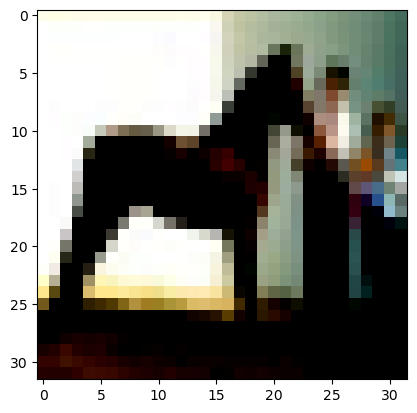

In [34]:
for img, label in train_dataloader:
    print(img.shape)
    print(label.shape)
    print(label)
    print(label[0])
    plt.imshow(img[0].permute(1, 2, 0))
    break


In [35]:
class EarlyStopCallBack:
    def __init__(self, patience = 5, min_delta = 0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_metric = -1
    
    def __call__(self, metric):
        if metric > self.best_metric + self.min_delta:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
    
    @property
    def early_stop(self):
        return self.counter >= self.patience

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super().__init__()
        self.activation = F.relu

        self.conv1 = nn.Conv2d(in_channels,  out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        act = self.activation

        fx = self.conv1(x)
        fx = self.bn1(fx)
        fx = act(fx)

        fx = self.conv2(fx)
        fx = self.bn2(fx)

        if self.downsample is not None:
            x = self.downsample(x)

        return act(fx + x)


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)  # 32*32 -> 16*16
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)    # 16*16 -> 8*8
        self.conv2_x = nn.Sequential(
            ResBlock(in_channels=64,  out_channels=64,  kernel_size=3, padding=1),
            ResBlock(in_channels=64,  out_channels=64,  kernel_size=3, padding=1)
        )   # 8*8 -> 8*8
        self.conv3_x = nn.Sequential(
            ResBlock(in_channels=64,  out_channels=128, kernel_size=3, stride=2, padding=1),
            ResBlock(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        )   # 8*8 -> 4*4
        self.conv4_x = nn.Sequential(
            ResBlock(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            ResBlock(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        )   # 4*4 -> 2*2
        self.conv5_x = nn.Sequential(
            ResBlock(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            ResBlock(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        )   # 2*2 -> 1*1
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = self.fc(self.flatten(x))

        return x

In [37]:
@torch.no_grad()
def evaludating(model, valid_dataloader, loss_function):
    loss_list = []
    pred_list = []
    label_list = []

    for imgs, labels in valid_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        preds = logits.argmax(axis=-1)
        loss = loss_function(logits, labels)

        loss_list.append(loss.item())
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)

    return np.mean(loss_list), acc

In [ ]:
def training(
        model,
        train_dataloader,
        valid_dataloader,
        loss_function,
        optimizer,
        epoch,
        early_stop_cb=None,
        eval_step=500
):
    model.train()

    record_dict = {"train":[], "valid":[]}
    global_step = 0

    with tqdm(total=epoch * len(train_dataloader)) as pbar:
        for epoch_id in range(epoch):
            for imgs, labels in train_dataloader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                logits = model(imgs)
                loss = loss_function(logits, labels)
                loss.backward()
                optimizer.step()

                loss = loss.cpu().item()
                preds = logits.argmax(axis=-1)
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                record_dict["train"].append({"loss":loss, "acc":acc, "step":global_step})

                if global_step % eval_step == 0:
                    model.eval()
                    valid_loss, valid_acc = evaludating(model, valid_dataloader, loss_function)
                    print(f"step : {global_step}, loss : {valid_loss}, acc :{valid_acc}")
                    record_dict["valid"].append({"loss":valid_loss, "acc":valid_acc, "step":global_step})
                    model.train()
                    
                    if early_stop_cb is not None:
                        early_stop_cb(valid_acc)
                        if early_stop_cb.early_stop:
                            print(f"Early Stop at step:{epoch_id} / global_step:{global_step}")
                            return record_dict
                
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch_id":epoch_id})
    
    return record_dict

In [56]:
model = ResNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
early_stop_cb = EarlyStopCallBack(patience=10)
epoch = 10
record = training(model, train_dataloader, valid_dataloader, loss_function, optimizer, epoch, early_stop_cb, eval_step=len(train_dataloader))

  0%|          | 0/31250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def plot_learning_curve(record_dict, sample_step=100):
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    valid_df = pd.DataFrame(record_dict["valid"]).set_index("step")
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5*fig_num, 5))

    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(valid_df.index, valid_df[item], label=f"valid_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curve(record)